<a href="https://colab.research.google.com/github/vitroid/PythonTutorials/blob/master/Pending/315%E6%99%82%E7%B3%BB%E5%88%97%E3%83%87%E3%83%BC%E3%82%BF%E3%81%AE%E4%BA%88%E6%B8%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 時系列データの予測

時間変化するデータから、その先を予測する手法を紹介します。



## 1. Recurrent Neural Network

ニューラルネットワーク(NN)についてはすでに何度か紹介しています。神経細胞を模した「ノード」をネットワークでつなぎ、その上を信号を伝達する過程で、信号情報の汎化を行う装置です。NNによる文字認識では、文字という画像の情報を、文字コードという少数の記号に変換します。

Recurrent Neural Networkは、時間的に等間隔のデータの列を学習して、未来を予測するのに特化したNNです。

基本的な構造は、次のようになります。


In [1]:
import pandas as pd

df = pd.read_csv("https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_mlo.csv", sep=",", comment="#")
df

,year,month,decimal date,average,deseasonalized,ndays,sdev,unc
0,1958,3,1958.2027,315.70,314.43,-1,-9.99,-0.99
1,1958,4,1958.2877,317.45,315.16,-1,-9.99,-0.99
2,1958,5,1958.3699,317.51,314.71,-1,-9.99,-0.99
3,1958,6,1958.4548,317.24,315.14,-1,-9.99,-0.99
4,1958,7,1958.5370,315.86,315.18,-1,-9.99,-0.99
...,...,...,...,...,...,...,...,...
771,2022,6,2022.4583,420.99,418.61,28,0.30,0.11
772,2022,7,2022.5417,418.90,418.58,27,0.57,0.21
773,2022,8,2022.6250,417.19,419.16,27,0.37,0.14
774,2022,9,2022.7083,415.95,419.49,28,0.41,0.15


In [2]:
co2 = df["average"]


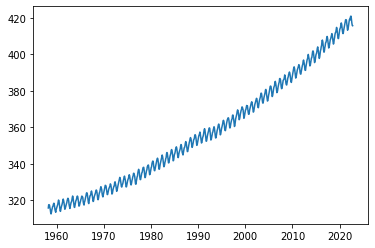

In [3]:
import matplotlib.pyplot as plt

plt.plot(df["decimal date"], df["average"])

In [4]:
import numpy as np

# 標準化する。ここで決めた平均と標準偏差は、今後ずっとそのまま使う。
arr = co2.to_numpy()
mean = np.mean(arr, axis=0)
std  = np.std(arr, axis=0)
nor = (arr - mean) / std
nor

array([-1.37439722e+00, -1.31697520e+00, -1.31500645e+00, -1.32386584e+00,
       -1.36914721e+00, -1.39966291e+00, -1.45642867e+00, -1.48169436e+00,
       -1.45216303e+00, -1.40819418e+00, -1.37833473e+00, -1.34880341e+00,
       -1.34322527e+00, -1.30811581e+00, -1.28941264e+00, -1.29400640e+00,
       -1.34683465e+00, -1.40392854e+00, -1.43542862e+00, -1.45216303e+00,
       -1.40360042e+00, -1.37833473e+00, -1.35044404e+00, -1.33239712e+00,
       -1.31270957e+00, -1.26513133e+00, -1.23199062e+00, -1.24675628e+00,
       -1.29302202e+00, -1.36783470e+00, -1.42460047e+00, -1.43575674e+00,
       -1.39736603e+00, -1.35831905e+00, -1.33535025e+00, -1.30877206e+00,
       -1.28120949e+00, -1.25036566e+00, -1.21427183e+00, -1.24085002e+00,
       -1.28022511e+00, -1.33863151e+00, -1.39769415e+00, -1.38719413e+00,
       -1.36127219e+00, -1.33141274e+00, -1.30089704e+00, -1.28088136e+00,
       -1.24380315e+00, -1.21459995e+00, -1.19983429e+00, -1.21295932e+00,
       -1.24610003e+00, -

In [5]:
def data_shaping(df, length=300, leap=1):
    """全データから、適切な長さの学習用データセットを構成する。

    df: 全データ
    length: 学習に使う連続データ数。
    leap: 連続データから何個先を教師データとするか。リストで複数指定できる。
    """
    X = []
    Y = []
    for head in range(len(df)-(length+max(leap))):
        X.append(df[head:head+length])
        Y.append(df[head+length+leap-1])
    return np.array(X), np.array(Y)


In [7]:
from tensorflow.keras import activations
from tensorflow import keras
from keras import layers

leaps = np.array([1,2,4,8])
length=30
Xtrain, ytrain = data_shaping(nor, length=length, leap=leaps)
cols = Xtrain.shape[1]
model = keras.Sequential()
model.add(layers.LSTM(3, batch_input_shape=(None, cols, 1)))
model.add(layers.Dense(len(leaps), activation=activations.linear))
model.compile(loss='mean_squared_error', optimizer='adam')


In [12]:
model.fit(Xtrain, ytrain, batch_size=256, epochs=500, verbose=1, validation_split=0.2)
model.summary()

Epoch 1/500
3/3 [==============================] - 0s 47ms/step - loss: 0.0074 - val_loss: 0.4075
Epoch 2/500
3/3 [==============================] - 0s 29ms/step - loss: 0.0074 - val_loss: 0.4071
Epoch 3/500
3/3 [==============================] - 0s 29ms/step - loss: 0.0074 - val_loss: 0.4067
Epoch 4/500
3/3 [==============================] - 0s 29ms/step - loss: 0.0074 - val_loss: 0.4063
Epoch 5/500
3/3 [==============================] - 0s 31ms/step - loss: 0.0074 - val_loss: 0.4059
Epoch 6/500
3/3 [==============================] - 0s 32ms/step - loss: 0.0074 - val_loss: 0.4056
Epoch 7/500
3/3 [==============================] - 0s 29ms/step - loss: 0.0074 - val_loss: 0.4051
Epoch 8/500
3/3 [==============================] - 0s 28ms/step - loss: 0.0074 - val_loss: 0.4046
Epoch 9/500
3/3 [==============================] - 0s 28ms/step - loss: 0.0074 - val_loss: 0.4042
Epoch 10/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0073 - val_loss: 0.4038
Epoch 11/500
3/3 [=

24/24 [==============================] - 0s 3ms/step


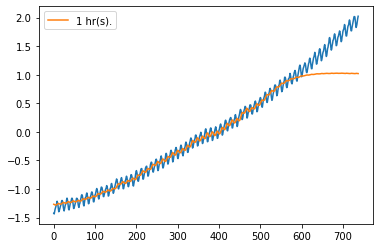

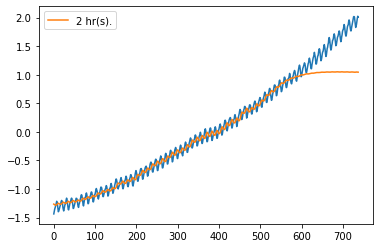

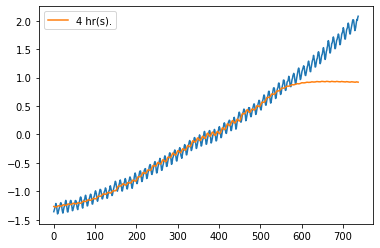

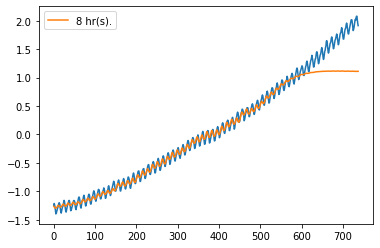

In [13]:
import matplotlib.pyplot as plt

# 予測させる。
pred = model.predict(Xtrain)
# 学習に使ったデータを使っているので合って当然。
for i, leap in enumerate(leaps):
    plt.plot(ytrain[:,i])
    plt.plot(pred[:,i], label=f"{leap} hr(s).")
    plt.legend()
    plt.show()